# Project: Ukrainian coffee shops

### Project Brief

You are on the data science team for a coffee company that is looking to expand their business into Ukraine. They want to get an understanding of the existing coffee shop market there.

You have a dataset from Google businesses. It contains information about coffee shops in Ukraine. The marketing manager wants to identify the key coffee shop segments. They will use this to construct their marketing plan. In their current location, they split the market into 5 segments. The marketing manager wants to know how many segments are in this new market, and their key features.

You will be presenting your findings to the Marketing Manager, who has no data science background.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer


import warnings
warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

In [214]:
shops = pd.read_csv('data/coffee_shops.csv')
shops.head(3)

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,NaN,NaN,NaN
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,NaN,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,NaN,NaN,True


In [215]:
print('Overall dataset length:', len(shops))
print('Number of rows with missing values:', len(shops[shops.isnull().any(axis=1)]))

Overall dataset length: 200
Number of rows with missing values: 121


In [216]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           198 non-null    float64
 4   Reviews          198 non-null    float64
 5   Price            122 non-null    object 
 6   Delivery option  129 non-null    object 
 7   Dine in option   140 non-null    object 
 8   Takeout option   144 non-null    object 
dtypes: float64(2), object(7)
memory usage: 14.2+ KB


## Missing values 
If we look below, we can make sense of both "Takeout" and "Dine in" options, we could simply set the missing values to False. However, it's more logical to look at possible situation where all the three columns (takeout, dine in, and delivery) might be false. Therefore:
1. Look into the place types that won't require dine in options. Here, those places would be: store, internet shop, e-commerce service, 

### Delivery, Dine in, Takeout columns 

In [217]:
print(shops['Takeout option'].value_counts())
print(shops['Dine in option'].value_counts())
print(shops['Delivery option'].value_counts())

True    144
Name: Takeout option, dtype: int64
True    140
Name: Dine in option, dtype: int64
False    94
True     35
Name: Delivery option, dtype: int64


In [218]:
shops[shops[['Takeout option', 'Dine in option', 'Delivery option']].isnull().all(axis=1)]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,NaN,NaN,NaN
35,Poltava,"ПЕРША ДЕГУСТАЦІЙНА ЗАЛА КАВИ ""GANGSTER_COFFEE ...",Coffee store,5.0,37.0,NaN,NaN,NaN,NaN
38,Poltava,ЗАКУТОК - coffee hookah point,Coffee shop,5.0,15.0,NaN,NaN,NaN,NaN
60,Zaporozhye,Art Coffee,Espresso bar,4.6,11.0,NaN,NaN,NaN,NaN
63,Zaporozhye,"Мастерская ""Кофе на разлив""",Appliance repair service,5.0,15.0,NaN,NaN,NaN,NaN
66,Zaporozhye,Dim Kavy,Espresso bar,4.8,118.0,$$,NaN,NaN,NaN
67,Zaporozhye,"Интернет-магазин ""Kava-e""",Coffee store,4.7,121.0,NaN,NaN,NaN,NaN
68,Zaporozhye,Coffee House,Store,4.7,132.0,NaN,NaN,NaN,NaN
70,Zaporozhye,Caffisimo,Espresso bar,4.5,223.0,$$,NaN,NaN,NaN
82,Odessa,Кофе База Одесса | Coffee Baza,Store,5.0,10.0,NaN,NaN,NaN,NaN


In [219]:
idx = shops[shops['Place type'].isin(['Internet shop', 'Coffee stand', 
                                      'E-commerce service', 'Appliance repair service'])].index

cols = ['Delivery option', 'Takeout option']
shops.loc[idx, 'Dine in option'] = False
shops.loc[idx, cols] = shops.loc[idx, cols].fillna(False)

# check out the results
shops.loc[idx, :]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
61,Zaporozhye,Art Coffee - Інтернет Магазин Кави та Чаю,Internet shop,5.0,12.0,NaN,True,False,False
63,Zaporozhye,"Мастерская ""Кофе на разлив""",Appliance repair service,5.0,15.0,NaN,False,False,False
69,Zaporozhye,Jays : Coffee Brewers,Coffee stand,4.5,167.0,$$,False,False,True
141,Kiev,"""®КАВА БАЗА®""",E-commerce service,5.0,21.0,NaN,False,False,False


In [220]:
# fill in the rest of the values with False
cols = ['Takeout option', 'Dine in option', 'Delivery option']

shops[cols] = shops[cols].fillna(False)

In [221]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           198 non-null    float64
 4   Reviews          198 non-null    float64
 5   Price            122 non-null    object 
 6   Delivery option  200 non-null    bool   
 7   Dine in option   200 non-null    bool   
 8   Takeout option   200 non-null    bool   
dtypes: bool(3), float64(2), object(4)
memory usage: 10.1+ KB


In [365]:


shops[shops['Place name'].duplicated(keep=False)]



,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Division,cluster
23,Poltava,Coffee House,Cafe,4.7,329.0,$$,False,False,True,County,1
45,Kherson,coffee House,Coffee shop,4.7,279.0,$$,False,True,True,County,1
66,Zaporozhye,Dim Kavy,Espresso bar,4.8,118.0,$$,True,False,False,City,1
68,Zaporozhye,Coffee House,Store,4.7,132.0,$$,True,False,False,City,1
71,Zaporozhye,MY COFFEE,Coffee shop,4.5,341.0,$$,False,True,True,City,1
97,Odessa,MY COFFEE,Coffee shop,4.8,150.0,$$,False,True,True,Metropolis,1
100,Lviv,Lviv Coffee Manufacture,Coffee shop,4.7,17937.0,$$,True,True,True,City,1
101,Lviv,Svit Kavy,Coffee shop,4.6,2931.0,$$,False,True,True,City,1
107,Lviv,Svit Kavy,Coffee shop,4.3,102.0,$$,False,True,True,City,1
108,Lviv,Lviv Coffee Manufacture,Coffee shop,4.5,778.0,$$,False,True,True,City,1


### Rating & Reviews columns

From what we see below, these two values are pretty useless as they have no meaninful information in terms of ratings and reviews. Moreover, they have all the operational functions disabled. Therefore, we will just remove them. 

In [222]:
shops[shops['Reviews'].isna()]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
49,Kherson,Кофе В Херсоне,Cafe,NaN,NaN,NaN,False,False,False
186,Dnipro,"Coffee&Cake, Game zone PS4",Coffee shop,NaN,NaN,NaN,False,False,False


In [223]:
shops.drop(index=[49, 186], axis='rows', inplace=True)

shops.reset_index(drop=True)

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,False,False,False
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,False,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,False,False,True
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,NaN,False,True,True
...,...,...,...,...,...,...,...,...,...
193,Dnipro,Artist,Restaurant,4.6,963.0,$$$,False,True,True
194,Dnipro,Dream Cafe,Cafe,4.3,646.0,$$,False,True,True
195,Dnipro,РУТА КАФЕ ПП КУЛІЧЕНКО К.І.,Cafe,4.6,16.0,$$,False,True,True
196,Dnipro,Ob'yektna Kava,Coffee shop,4.7,599.0,$$,False,True,True


In [224]:
# set Delivery option to True if last two columns are False 
mask = shops[(shops['Dine in option'] == False) & (shops['Takeout option'] == False)]
shops.loc[mask.index, 'Delivery option'] = True
shops

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,True,False,False
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,False,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,False,False,True
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,NaN,False,True,True
...,...,...,...,...,...,...,...,...,...
195,Dnipro,Artist,Restaurant,4.6,963.0,$$$,False,True,True
196,Dnipro,Dream Cafe,Cafe,4.3,646.0,$$,False,True,True
197,Dnipro,РУТА КАФЕ ПП КУЛІЧЕНКО К.І.,Cafe,4.6,16.0,$$,False,True,True
198,Dnipro,Ob'yektna Kava,Coffee shop,4.7,599.0,$$,False,True,True


<AxesSubplot:>

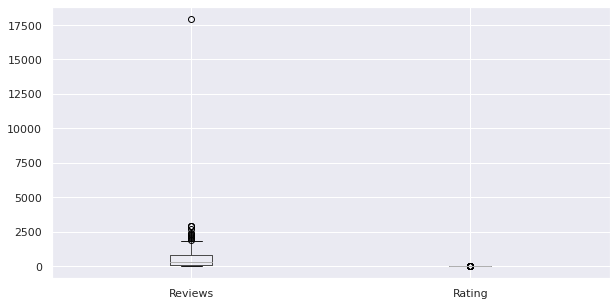

In [366]:
shops[['Reviews', 'Rating']].boxplot()

In [367]:
shops[shops['Reviews'] > shops['Reviews'].std() * 3]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Division,cluster
100,Lviv,Lviv Coffee Manufacture,Coffee shop,4.7,17937.0,$$,True,True,True,City,1


In [378]:
shops.drop(index=100, axis='rows').reset_index(drop=True)

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Division,cluster
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,$$,True,False,False,City,1
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,False,True,City,1
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,$$,False,False,True,City,1
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True,City,1
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,$$,False,True,True,City,1
...,...,...,...,...,...,...,...,...,...,...,...
192,Dnipro,Artist,Restaurant,4.6,963.0,$$$,False,True,True,City,2
193,Dnipro,Dream Cafe,Cafe,4.3,646.0,$$,False,True,True,City,1
194,Dnipro,РУТА КАФЕ ПП КУЛІЧЕНКО К.І.,Cafe,4.6,16.0,$$,False,True,True,City,1
195,Dnipro,Ob'yektna Kava,Coffee shop,4.7,599.0,$$,False,True,True,City,1


### Price column


ValueError: min() arg is an empty sequence

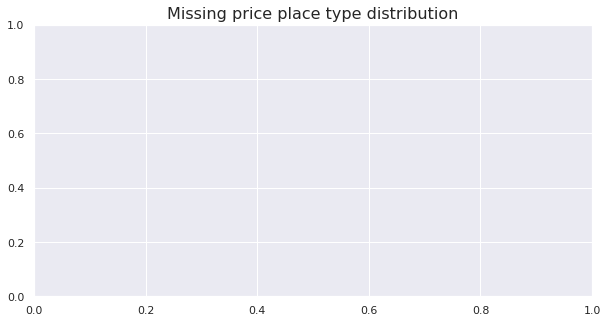

In [370]:
plt.title('Missing price place type distribution', fontsize=16)
sns.countplot(data=shops[shops.Price.isna()], y='Place type')
plt.show()

In [226]:
shops.fillna('$$', inplace=True)

## Exploratory Data Analysis

To better understand the data at hand, I want to get answers for the following questions:

1. What's the most common place in each region?
2. What are the reviews for the most popular places?
3. What's the best rated place in each region?
4. Do big cities have different trends than the smaller ones?
5. Do prices/reviews/ratings differ if there's a delivery option?


To start answering the questions, let's first google some information about the Ukrainian cities and their populations.

| Region | Population | Most Common Place | Most Reviews | 
| --- | --- | --- | --- |
| Kyiv (Kiev) | 2,962,180 | NaN | NaN |
| Kharkiv | 1,433,886 | NaN | NaN |
| Odessa | 1,015,826 | NaN | NaN |
| Dnipro | 980,948 | NaN | NaN |
| Zaporozhye | 722,713 | NaN | NaN |
| Lviv | 721,510 | NaN | NaN |
| Khrivoy Rog | 612,750 | NaN | NaN |
| Mariupol | 431,859 | NaN | NaN |
| Kherson | 283,649 | NaN | NaN |
| Poltava | 283,402 | NaN | NaN |

In [227]:
regions = shops['Region'].unique().tolist()
print(f'There are {len(regions)} regions:', ', '.join(regions))

There are 10 regions: Mariupol, Poltava, Kherson, Zaporozhye, Odessa, Lviv, Khrivoy Rog, Kiev, Kharkiv, Dnipro


### Question 1: What's the most common place in each region?

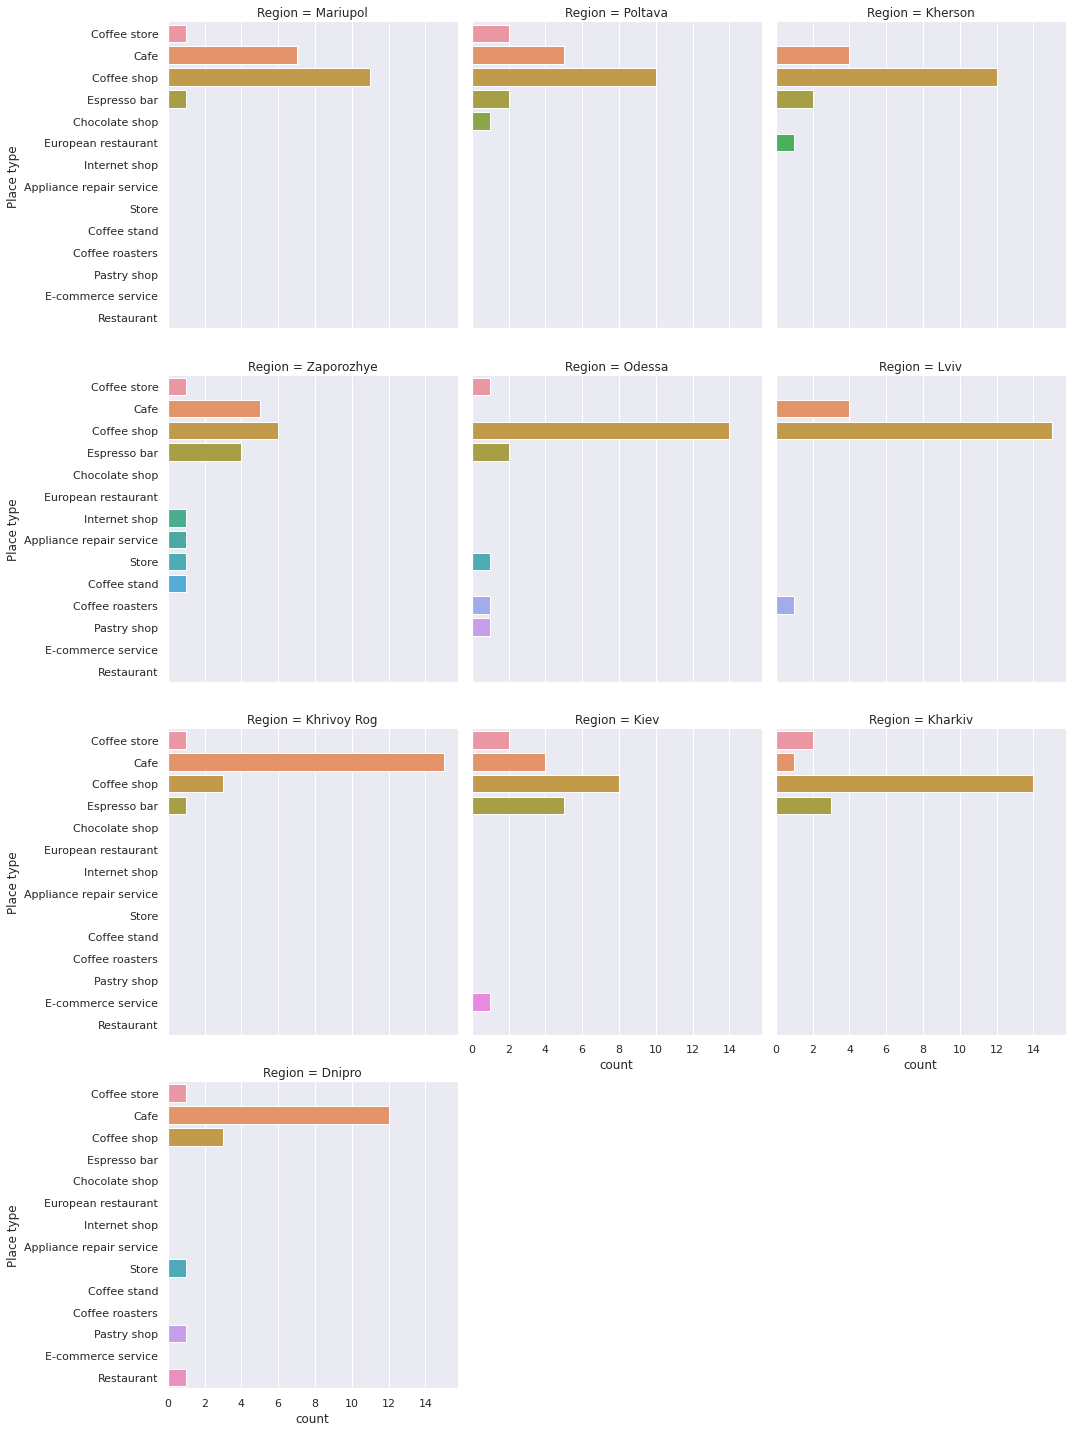

In [379]:
sns.catplot(data=shops, y='Place type', kind='count', 
            col='Region', col_wrap=3)
plt.show()

#### Insights

- Majority of the cities have more coffee shops than cafes, restaurants, and any other places. 
- Dnipro and Khrivoy Rog have more cafes than coffee shops

### Question 2: What are the reviews for the most popular places?

In [380]:
shops.groupby(['Region', 'Place type']).agg({'Rating': np.median, 'Reviews': np.median, 
                                              'Price': mode, 'Place name': 'count'}).reset_index().\
sort_values('Reviews', ascending=False).groupby('Region').first()

,Place type,Rating,Reviews,Price,Place name
Region,,,,,
Dnipro,Pastry shop,4.7,2381.0,$$$,1
Kharkiv,Coffee shop,4.6,401.5,$$,14
Kherson,European restaurant,4.5,1345.0,$$,1
Khrivoy Rog,Coffee shop,4.7,455.0,$$,3
Kiev,Cafe,4.7,1457.0,$$,4
Lviv,Coffee roasters,4.6,1199.0,$$,1
Mariupol,Espresso bar,4.6,367.0,$$,1
Odessa,Espresso bar,4.8,725.5,$$,2
Poltava,Chocolate shop,4.6,1376.0,$$,1


### Question 3: What's the best rated place in each region?

In [381]:
shops.groupby(['Region', 'Place type']).agg({'Rating': np.median, 'Reviews': np.median, 
                                              'Price': mode, 'Place name': 'count'}).reset_index().\
sort_values('Rating', ascending=False).groupby('Region').first()

,Place type,Rating,Reviews,Price,Place name
Region,,,,,
Dnipro,Store,4.90,39.0,$$,1
Kharkiv,Espresso bar,4.60,268.0,$$,3
Kherson,Espresso bar,4.70,36.5,$$,2
Khrivoy Rog,Espresso bar,4.80,49.0,$$,1
Kiev,E-commerce service,5.00,21.0,$$,1
Lviv,Cafe,4.75,863.5,$$,4
Mariupol,Coffee shop,4.80,112.0,$$,11
Odessa,Coffee roasters,5.00,15.0,$$,1
Poltava,Coffee store,4.85,192.0,$$,2


### Insights

| Region | Population | Most Common Place | Most reviews | Most Rating
| --- | --- | --- | --- | --- |
| Kyiv (Kiev) | 2,962,180 | Coffee shop | Cafe | E-commerce service |
| Kharkiv | 1,433,886 | Coffee shop | Coffee shop | Espresso bar |
| Odessa | 1,015,826 | Coffee shop | Espresso bar | Coffee roasters |
| Dnipro | 980,948 | Cafe | Pastry shop | Store |
| Zaporozhye | 722,713 | Coffee shop | Cafe | Internet shop |
| Lviv | 721,510 | Coffee shop | Coffee roasters | Cafe |
| Khrivoy Rog | 612,750 | Cafe | Coffee shop | Espresso bar |
| Mariupol | 431,859 | Coffee shop | Espresso bar | Coffee shop |
| Kherson | 283,649 | Coffee shop | European restaurant | Espresso bar |
| Poltava | 283,402 | Coffee shop | Chocolate shop | Coffee store |

## Question 4: Do big cities have different trends than the smaller ones?

In order to answer the question, we will first define how big the "big" city is. After some googling, I found the following information:

| Term | Population | 
| --- | --- |
| Metropolis | 1,000,000 - 3,000,000 |
| City | 300,000 - 1,000,000 |
| County | 100,000 - 300,000 |

We see here that we can break the dataset into three categories: county, city, and metropolis. Let's compare the trends in each.

In [231]:
def mapping(x):
    if x in ['Kiev', 'Kharkiv', 'Odessa']:
        return 'Metropolis'
    if x in ['Kherson', 'Poltava']:
        return 'County'
    return 'City'


shops['Division'] = shops['Region'].apply(lambda x: mapping(x))
shops.head(3)

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Division
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,$$,True,False,False,City
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,False,True,City
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,$$,False,False,True,City


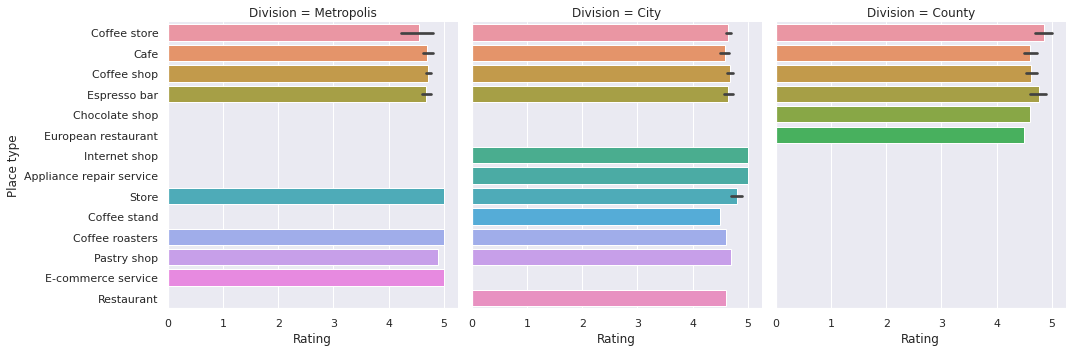

In [382]:
order = ['Metropolis', 'City', 'County']
g = sns.catplot(data=shops, y='Place type', x='Rating', 
                col='Division', kind='bar', col_order=order)

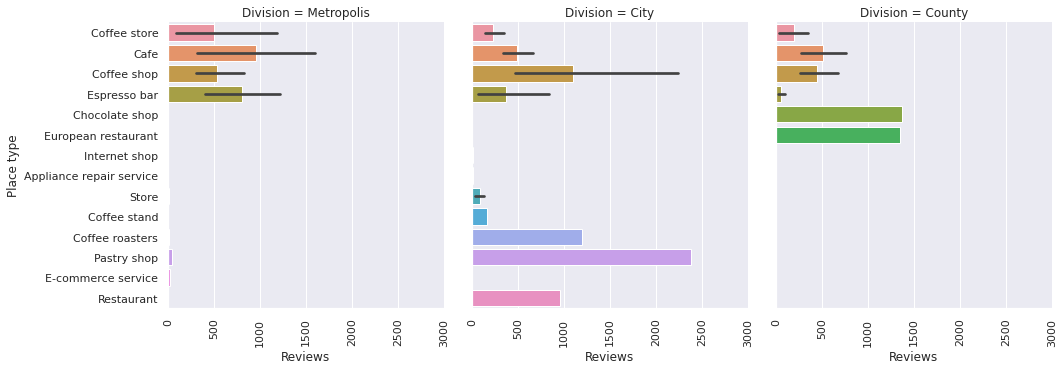

In [383]:
g = sns.catplot(data=shops, y='Place type', x='Reviews', 
                col='Division', kind='bar', col_order=order)
g.set_xticklabels(rotation=90)

### Insights

## Question 5: Do prices/reviews/ratings differ if there's a delivery option?

In [386]:
shops.groupby(['Division', 'Delivery option', 'Place type']).agg({'Reviews': [np.min, np.max, np.median],
                                                                  'Rating': [np.min, np.max, np.median],
                                                                  'Place type': 'count'})

Reviews                   \
                                                       amin     amax  median   
Division   Delivery option Place type                                          
City       False           Cafe                         9.0   2236.0   170.0   
                           Coffee roasters           1199.0   1199.0  1199.0   
                           Coffee shop                 10.0   2931.0   414.0   
                           Coffee stand               167.0    167.0   167.0   
                           Coffee store               401.0    401.0   401.0   
                           Espresso bar                49.0   1482.0   367.0   
                           Restaurant                 963.0    963.0   963.0   
           True            Appliance repair service    15.0     15.0    15.0   
                           Cafe                        38.0   1656.0   383.5   
                           Coffee shop                 24.0  17937.0   125.0   
                           Coffee store               121.0    206.0   185.0   
                           Espresso bar                11.0    223.0   118.0   
                           Internet shop               12.0     12.0    12.0   
                           Pastry shop               2381.0   2381.0  2381.0   
                           Store                       39.0    132.0    85.5   
County     False           Cafe                        15.0    860.0   329.0   
                           Chocolate shop            1376.0   1376.0  1376.0   
                           Coffee shop                 12.0   1201.0   258.0   
                           Espresso bar                14.0    124.0    36.5   
           True            Cafe                       598.0   1195.0   896.5   
                           Coffee shop                 15.0   1785.0  1091.5   
                           Coffee store                37.0    347.0   192.0   
                           European restaurant       1345.0   1345.0  1345.0   
Metropolis False           Cafe                        26.0   1737.0  1457.0   
                           Coffee shop                 21.0   2914.0   335.0   
                           Coffee store               222.0    222.0   222.0   
                           Espresso bar                35.0   1300.0   758.5   
                           Pastry shop                 47.0     47.0    47.0   
           True            Cafe                        96.0     96.0    96.0   
                           Coffee roasters             15.0     15.0    15.0   
                           Coffee shop                  3.0   2700.0    80.0   
                           Coffee store                10.0   1820.0   242.0   
                           E-commerce service          21.0     21.0    21.0   
                           Espresso bar                36.0   1908.0   831.0   
                           Store                       10.0     10.0    10.0   

                                                    Rating              \
                                                      amin amax median   
Division   Delivery option Place type                                    
City       False           Cafe                        3.9  5.0   4.60   
                           Coffee roasters             4.6  4.6   4.60   
                           Coffee shop                 4.3  5.0   4.60   
                           Coffee stand                4.5  4.5   4.50   
                           Coffee store                4.6  4.6   4.60   
                           Espresso bar                4.6  4.8   4.60   
                           Restaurant                  4.6  4.6   4.60   
           True            Appliance repair service    5.0  5.0   5.00   
                           Cafe                        4.0  5.0   4.60   
                           Coffee shop                 4.7  5.0   4.80   
                           Coffee store          

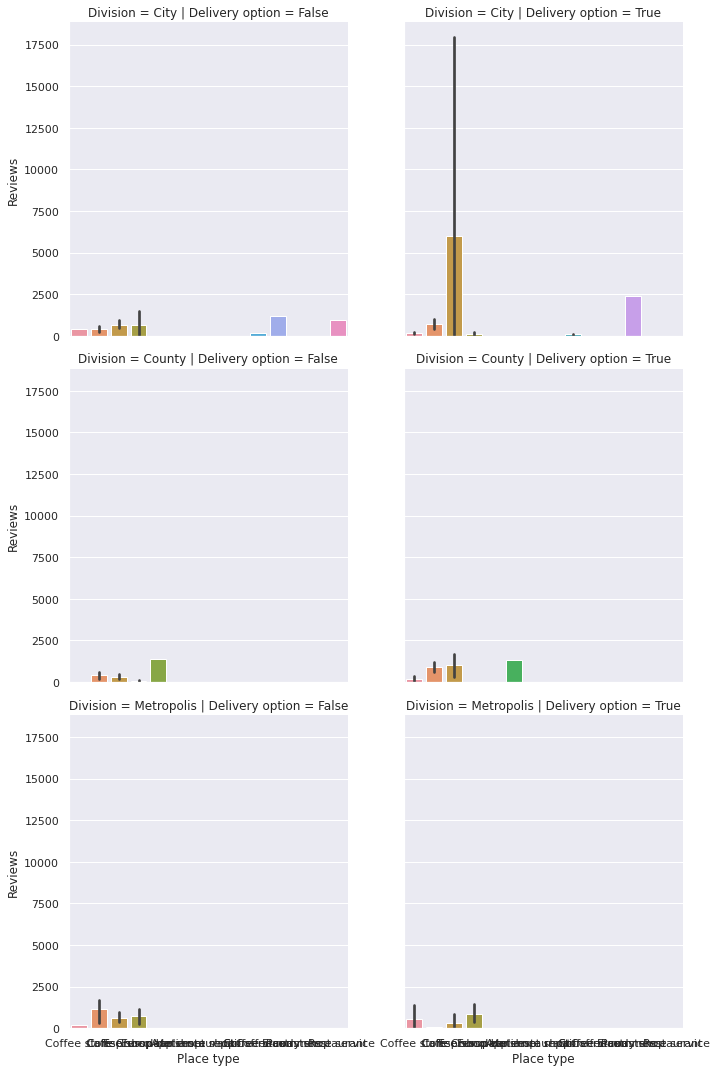

In [391]:
# sns.catplot(data=shops, col='Delivery option', 
#             y='Place type', kind='count', row='Division')


sns.catplot(data=shops, col='Delivery option',
            x='Place type', y='Reviews', kind='bar', row='Division')

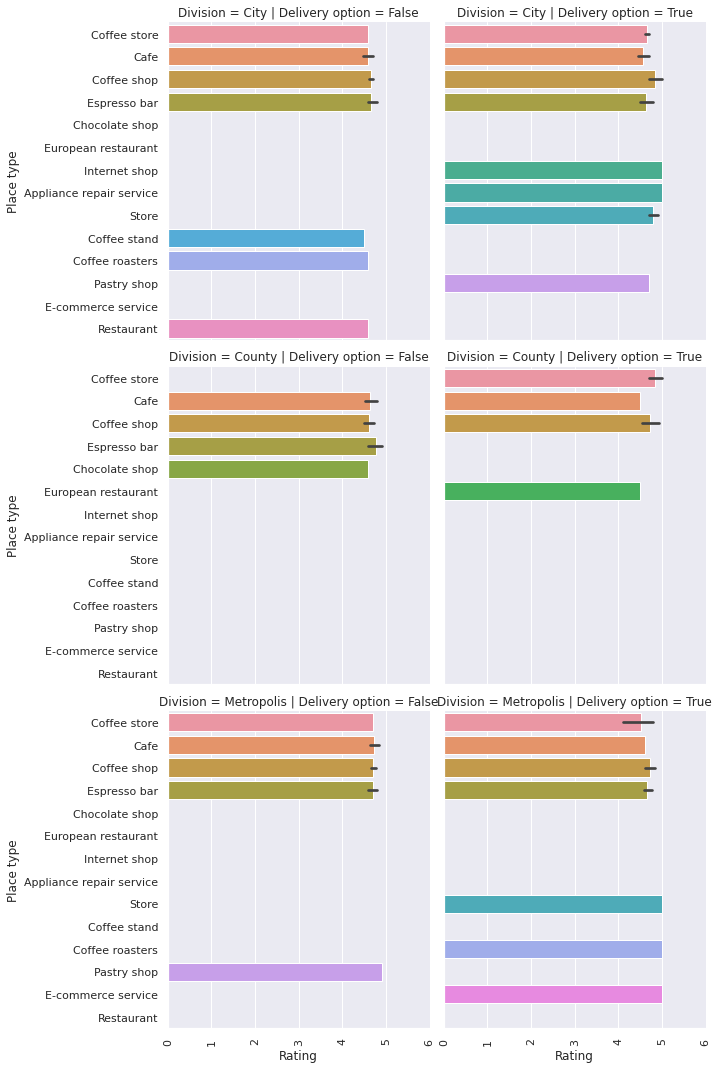

In [400]:
g = sns.catplot(data=shops, col='Delivery option',
                y='Place type', x='Rating', kind='bar', 
                row='Division')
g.set_xticklabels(rotation=90)

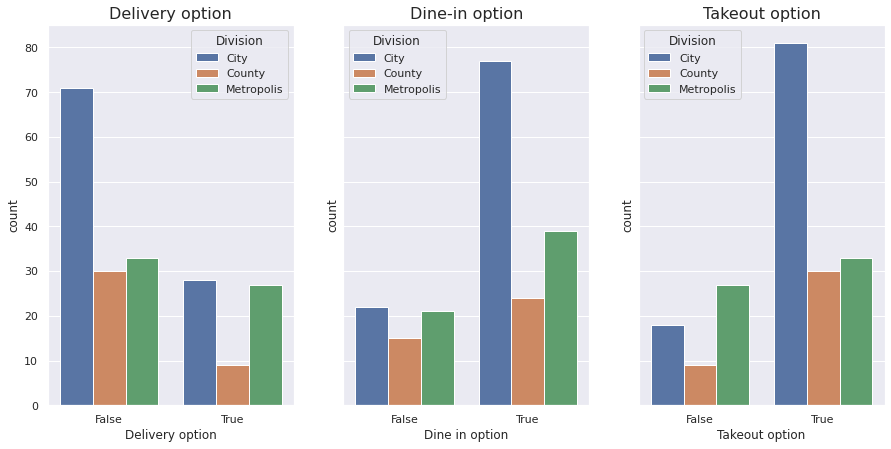

In [385]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7), sharey=True)

sns.countplot(data=shops, x='Delivery option', hue='Division', ax=ax[0])
sns.countplot(data=shops, x='Dine in option', hue='Division', ax=ax[1])
sns.countplot(data=shops, x='Takeout option', hue='Division', ax=ax[2])

ax[0].set_title('Delivery option', fontsize=16)
ax[1].set_title('Dine-in option', fontsize=16)
ax[2].set_title('Takeout option', fontsize=16)
plt.show()

In [318]:
cleaned = shops.drop('Place name', axis='columns')
cleaned = pd.get_dummies(cleaned, drop_first=True)
cleaned

,Rating,Reviews,Delivery option,Dine in option,Takeout option,Region_Kharkiv,Region_Kherson,Region_Khrivoy Rog,Region_Kiev,Region_Lviv,...,Place type_Espresso bar,Place type_European restaurant,Place type_Internet shop,Place type_Pastry shop,Place type_Restaurant,Place type_Store,Price_$$,Price_$$$,Division_County,Division_Metropolis
0,4.6,206.0,True,False,False,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,5.0,24.0,False,False,True,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,5.0,11.0,False,False,True,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4.4,331.0,False,True,True,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5.0,12.0,False,True,True,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,4.6,963.0,False,True,True,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
196,4.3,646.0,False,True,True,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
197,4.6,16.0,False,True,True,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
198,4.7,599.0,False,True,True,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [354]:
# Import necessary modules - scaling and hierarchical clustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.patches as patches

# Scaling features
scaled_features = pd.DataFrame(StandardScaler().fit_transform(cleaned), columns=cleaned.columns)

# Clustering
Z = linkage(scaled_features, method='complete')

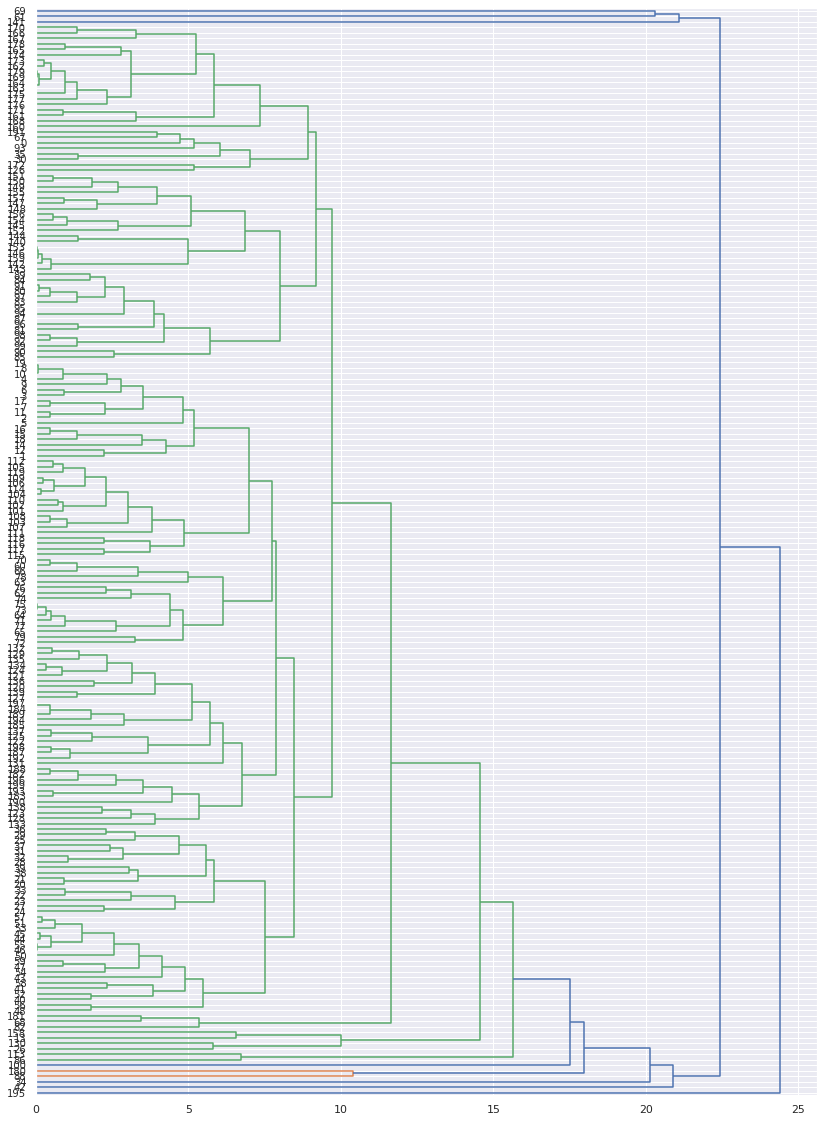

In [355]:


# Plot dendrogram and highlight cluster
fig, ax = plt.subplots(figsize=(14, 20))
dn = dendrogram(Z, labels=cleaned.index, orientation='right',
                leaf_rotation=0, leaf_font_size=10)
plt.show()

In [353]:
cleaned

,Rating,Reviews,Delivery option,Dine in option,Takeout option,Region_Kharkiv,Region_Kherson,Region_Khrivoy Rog,Region_Kiev,Region_Lviv,...,Place type_European restaurant,Place type_Internet shop,Place type_Pastry shop,Place type_Restaurant,Place type_Store,Price_$$,Price_$$$,Division_County,Division_Metropolis,cluster
0,4.6,206.0,True,False,False,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,5.0,24.0,False,False,True,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,5.0,11.0,False,False,True,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,4.4,331.0,False,True,True,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,5.0,12.0,False,True,True,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,4.6,963.0,False,True,True,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,5
196,4.3,646.0,False,True,True,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
197,4.6,16.0,False,True,True,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
198,4.7,599.0,False,True,True,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [356]:
fcluster(Z, 2, criterion='maxclust')

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1],
      dtype=int32)

In [361]:
shops[shops['Place type'] == 'Restaurant']

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Division,cluster
195,Dnipro,Artist,Restaurant,4.6,963.0,$$$,False,True,True,City,2


In [357]:
shops['cluster'] = fcluster(Z, 2, criterion='maxclust')

In [358]:
shops[shops['cluster'] == 1]['Place type'].value_counts()

Coffee shop                 96
Cafe                        57
Espresso bar                20
Coffee store                11
Store                        3
Coffee roasters              2
Pastry shop                  2
Chocolate shop               1
European restaurant          1
Internet shop                1
Appliance repair service     1
Coffee stand                 1
E-commerce service           1
Name: Place type, dtype: int64

In [359]:
shops[shops['cluster'] == 2]['Place type'].value_counts()

Restaurant    1
Name: Place type, dtype: int64

In [360]:
shops[shops['cluster'] == 3]['Place type'].value_counts()

Series([], Name: Place type, dtype: int64)

In [352]:
shops[shops['cluster'] == 4]['Place type'].value_counts()

Restaurant    1
Name: Place type, dtype: int64

In [338]:
shops[shops['cluster'] == 5]['Place type'].value_counts()

Series([], Name: Place type, dtype: int64)

<AxesSubplot:ylabel='Rating'>

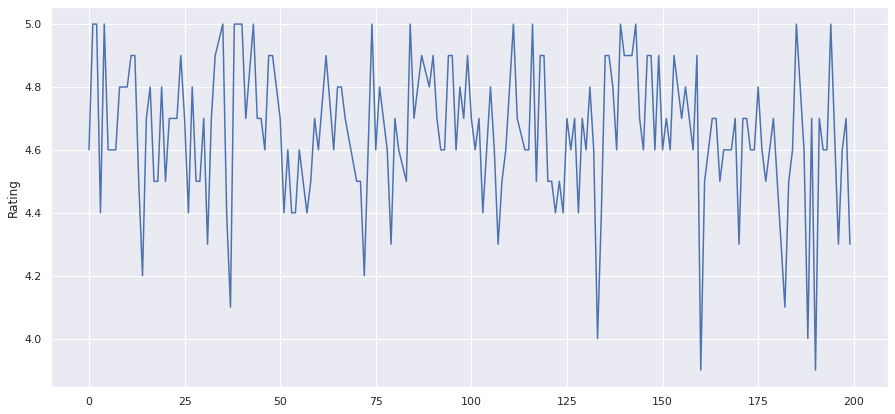

In [185]:
target = shops[shops['Place type'].isin(['Coffee shop', 'Cafe', 'Espresso bar', 'Coffee store'])]

plt.figure(figsize=(15, 7))
sns.lineplot(data=target['Rating'])

In [186]:
mode = lambda x: x.mode()

group = target.groupby(['Region', 'Place type']).agg({'Rating': np.median, 'Reviews': np.median, 
                                                      'Price': mode, 'Place name': 'count'})
group.reset_index(inplace=True)

In [190]:
shops.groupby(['Region', 'Place type']).agg({'Rating': np.median, 'Reviews': np.median, 
                                              'Price': mode, 'Place name': 'count'}).reset_index().\
sort_values(['Rating', 'Reviews'], ascending=False).groupby('Region').first()

,Place type,Rating,Reviews,Price,Place name
Region,,,,,
Dnipro,Store,4.90,39.0,$$,1
Kharkiv,Coffee shop,4.60,401.5,$$,14
Kherson,Espresso bar,4.70,36.5,$$,2
Khrivoy Rog,Espresso bar,4.80,49.0,$$,1
Kiev,E-commerce service,5.00,21.0,$$,1
Lviv,Cafe,4.75,863.5,$$,4
Mariupol,Coffee shop,4.80,112.0,$$,11
Odessa,Coffee roasters,5.00,15.0,$$,1
Poltava,Coffee store,4.85,192.0,$$,2


In [201]:
shops.groupby(['Region', 'Place type']).agg({'Rating': np.median, 'Reviews': np.median, 
                                              'Price': mode, 'Place name': 'count'}).reset_index().\
sort_values(['Reviews'], ascending=False).groupby('Region').first()

,Place type,Rating,Reviews,Price,Place name
Region,,,,,
Dnipro,Pastry shop,4.7,2381.0,$$$,1
Kharkiv,Coffee shop,4.6,401.5,$$,14
Kherson,European restaurant,4.5,1345.0,$$,1
Khrivoy Rog,Coffee shop,4.7,455.0,$$,3
Kiev,Cafe,4.7,1457.0,$$,4
Lviv,Coffee roasters,4.6,1199.0,$$,1
Mariupol,Espresso bar,4.6,367.0,$$,1
Odessa,Espresso bar,4.8,725.5,$$,2
Poltava,Chocolate shop,4.6,1376.0,$$,1


<Figure size 1080x504 with 0 Axes>

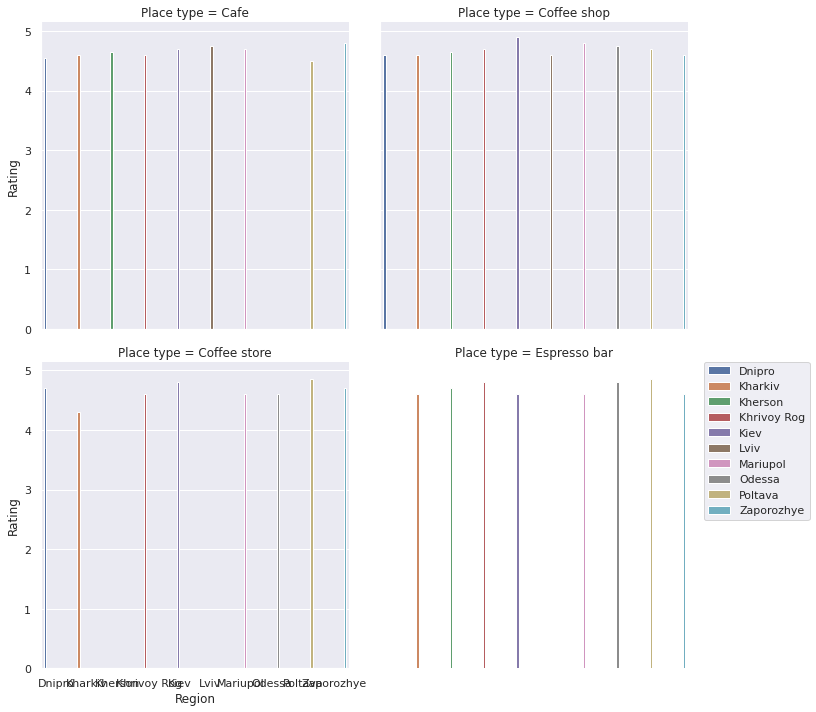

In [189]:
regions = group['Region'].unique().tolist()

plt.figure(figsize=(15, 7))
sns.catplot(data=group, y='Rating', x='Region', kind='bar', 
            col='Place type', col_wrap=2, hue='Region')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axis('off')
plt.show()

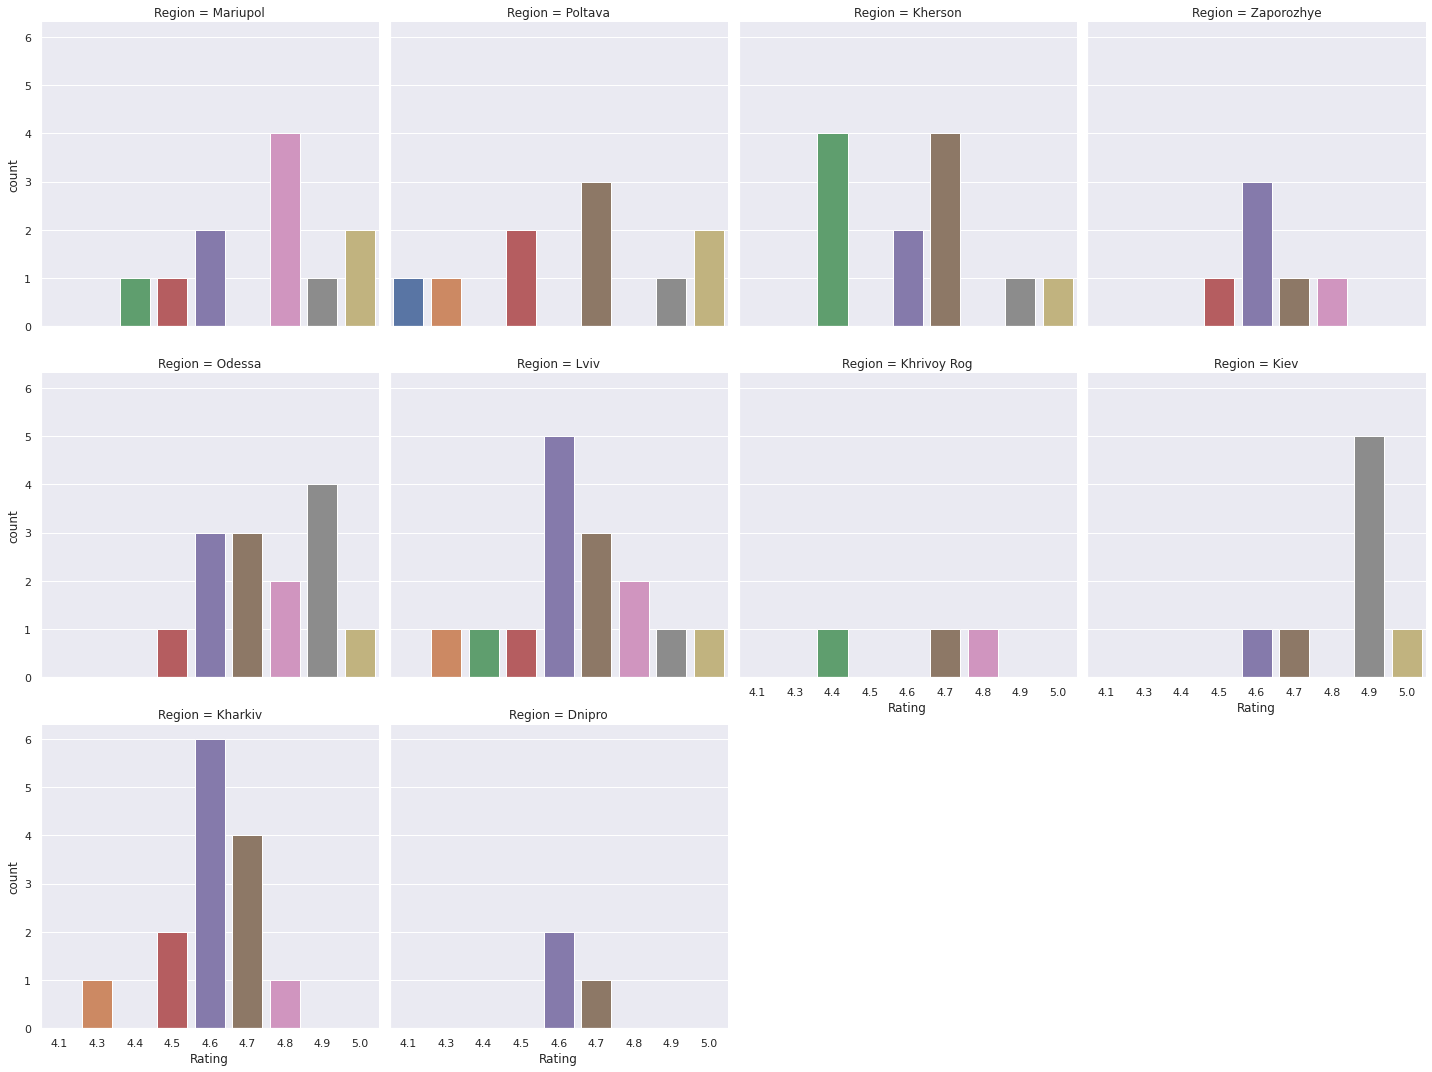

In [191]:
coffee_shops = shops[shops['Place type'] == 'Coffee shop']

sns.catplot(data=coffee_shops, x='Rating', col='Region', col_wrap=4, kind='count')

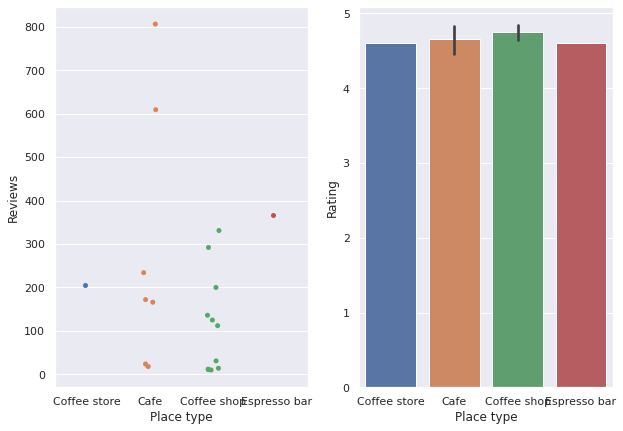

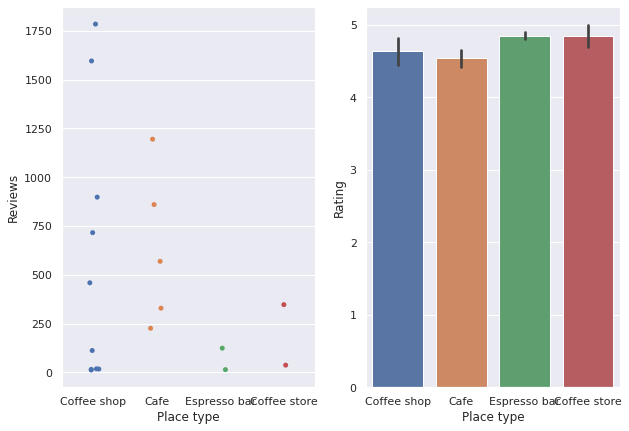

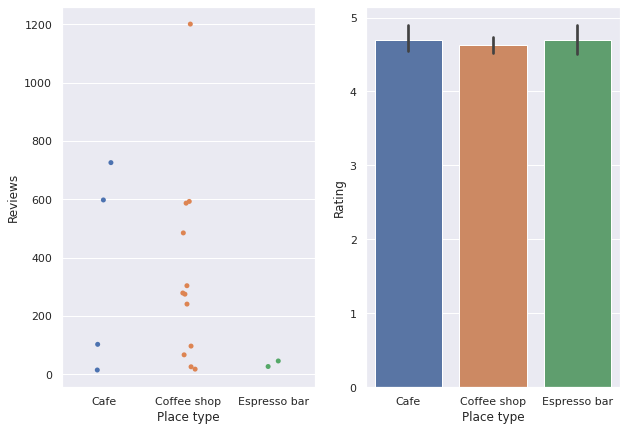

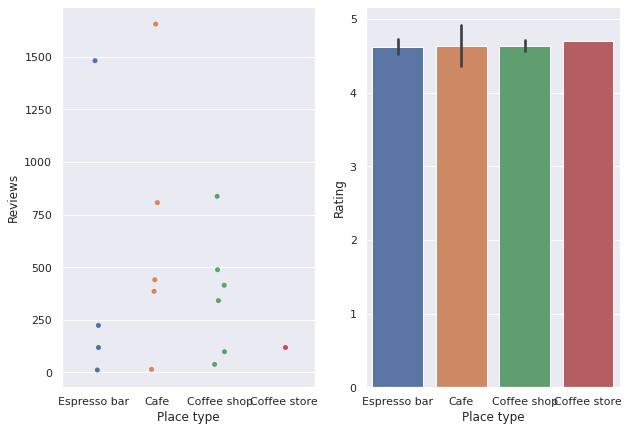

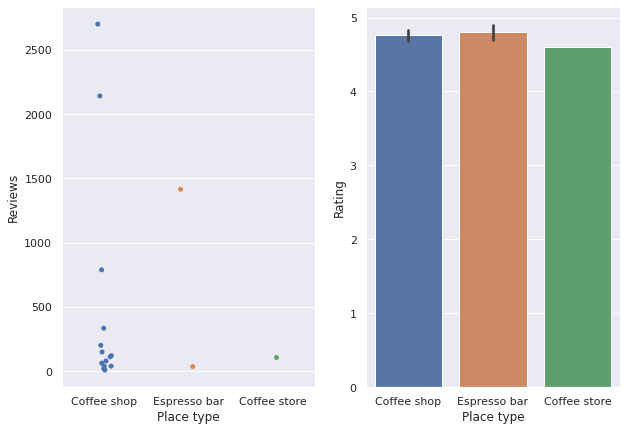

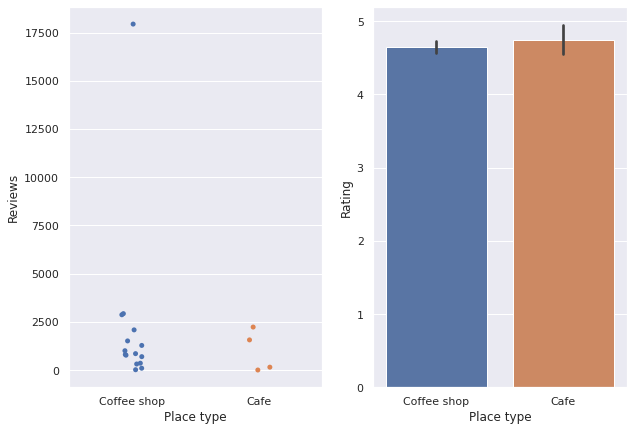

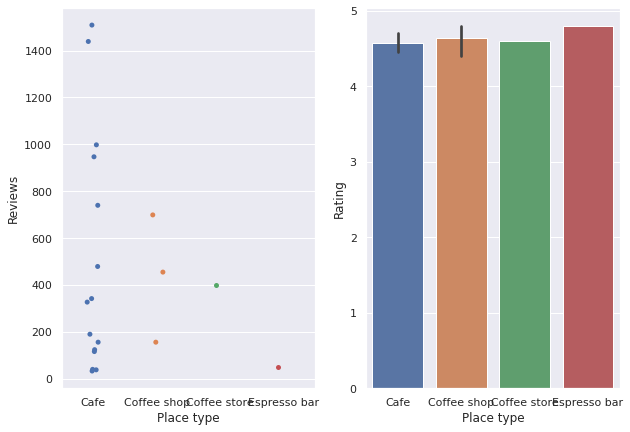

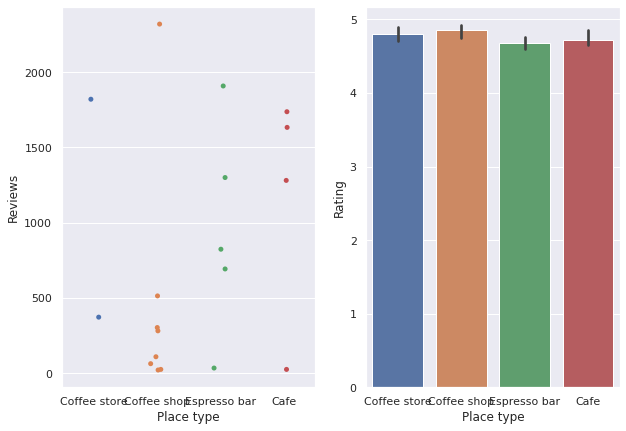

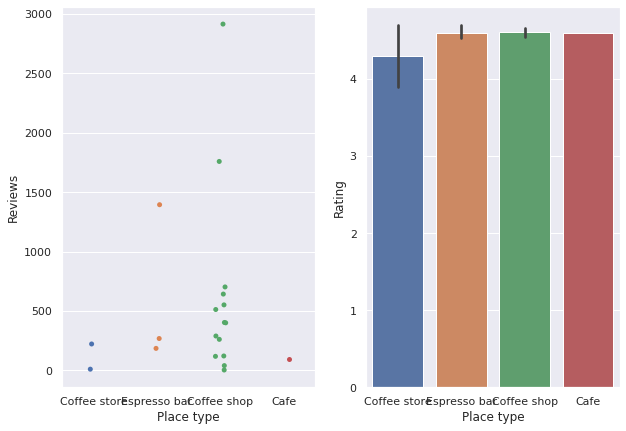

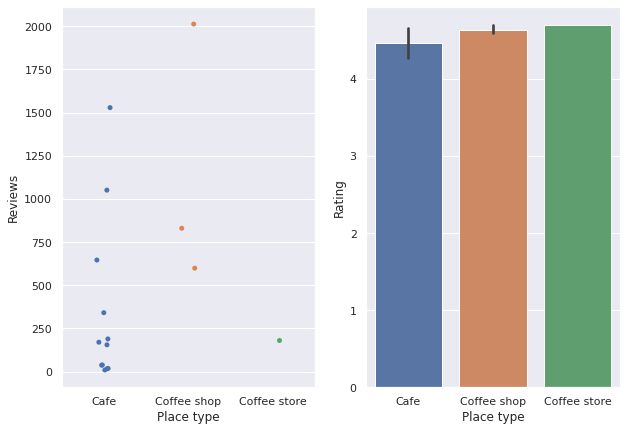

In [192]:
for region in shops['Region'].unique():
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.stripplot(data=target[target['Region'] == region], x='Place type', y='Reviews', ax=ax[0])
    sns.barplot(data=target[target['Region'] == region], x='Place type', y='Rating', ax=ax[1])

### Big cities vs Small

In [198]:
shops['Place type'].value_counts()

Coffee shop                 96
Cafe                        57
Espresso bar                20
Coffee store                11
Store                        3
Coffee roasters              2
Pastry shop                  2
Chocolate shop               1
European restaurant          1
Internet shop                1
Appliance repair service     1
Coffee stand                 1
E-commerce service           1
Restaurant                   1
Name: Place type, dtype: int64

In [193]:
len(shops['Place name'].unique())

185

In [211]:
# taking care of duplicates and/or misspelled words
def correct_names(place):
    place = place.lower()
    
    if place.startswith('dim ka'):
        return 'dim kavy'.title()
    if 'gangster' in place:
        return 'gangster coffee shop'.title()
    if 'art coffee' in place:
        return 'art coffee'.title()
    if place.startswith('смажимо каву'):
        return 'смажимо каву'.title()
    
    return place.title()

shops['Place name'] = shops['Place name'].apply(lambda x: correct_names(x))

In [212]:
len(shops['Place name'].unique())

177

In [196]:
common = shops['Place name'].value_counts().reset_index()
common = common[common['Place name'] > 1]['index']

shops[shops['Place name'].isin(common)]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,dim kavy,Coffee store,4.6,206.0,$$,False,False,False
23,Poltava,coffee house,Cafe,4.7,329.0,$$,False,False,True
30,Poltava,gangster coffee shop,Coffee store,4.7,347.0,$$,True,False,False
35,Poltava,gangster coffee shop,Coffee store,5.0,37.0,$$,False,False,False
45,Kherson,coffee house,Coffee shop,4.7,279.0,$$,False,True,True
47,Kherson,coffeeok,Coffee shop,4.9,18.0,$$,False,False,True
54,Kherson,coffee house,Coffee shop,4.4,67.0,$$,False,False,True
60,Zaporozhye,art coffee,Espresso bar,4.6,11.0,$$,False,False,False
61,Zaporozhye,art coffee,Internet shop,5.0,12.0,$$,True,False,False
66,Zaporozhye,dim kavy,Espresso bar,4.8,118.0,$$,False,False,False


In [162]:

shops.groupby('Place name').agg({'Place name': mode})

,Place name
Place name,
"""®КАВА БАЗА®""",False
"""Точка кофе""",False
"""Франс.уа"" кофейня-пекарня",False
Anso Coffee,False
Aroma kava,False
...,...
Смажимо каву в Одесі. Обсмажувальна №2,False
Смажимо каву. Обсмажувальна N3,False
Столовая BUFET,False
